#Importing Libraries

In [ ]:
import re
import nltk
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from wordcloud import STOPWORDS


In [ ]:
# Load dataset
df = pd.read_csv("training.1600000.processed.noemoticon1.csv", encoding="latin-1", header=None)

# Renaming columns
df.columns = ["sentiment", "ids", "date", "flag", "user", "tweet"]
df = df[["tweet", "sentiment"]]

# Checking dataset structure
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   tweet      1600000 non-null  object
 1   sentiment  1600000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


,tweet,sentiment
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


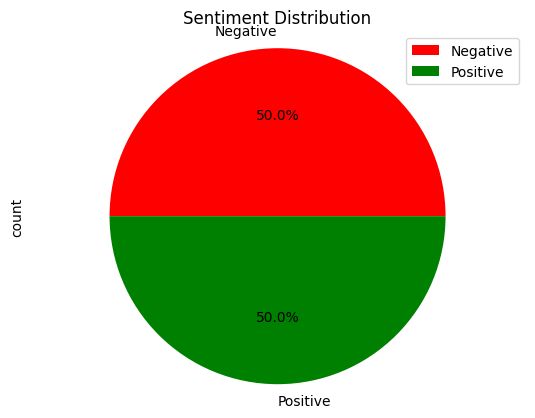

In [ ]:
# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))
stop_words.update(["amp", "rt", "lt", "gt"])  # Adding common noisy words

# Initialize the stemmer
stemmer = PorterStemmer()

# Function to clean tweets
def preprocess_tweet(text):
    text = text.lower()
    text = re.sub(r"https?://\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+|#", "", text)  # Remove mentions and hashtags
    text = re.sub(r"[^\w\s]|[\d]", "", text)  # Remove special characters & numbers
    text = " ".join([stemmer.stem(word) for word in text.split() if word not in stop_words])
    return text

# Apply text cleaning
df["clean_tweet"] = df["tweet"].apply(preprocess_tweet)

# Convert sentiment labels
df["sentiment"] = df["sentiment"].map({0: "Negative", 4: "Positive"})

# Plot sentiment distribution
df["sentiment"].value_counts().plot(kind="pie", autopct="%1.1f%%", colors=["red", "green"])
plt.title("Sentiment Distribution")
plt.axis("equal")
plt.legend(df["sentiment"].unique())
plt.show()

In [ ]:
# Feature engineering: Calculate tweet length
df["tweet_length"] = df["clean_tweet"].apply(lambda x: len(x.split()))

# Remove empty and duplicate tweets
df = df[df["tweet_length"] > 0].drop_duplicates(subset="clean_tweet").reset_index(drop=True)

# Display dataset shape after cleaning
print(f"Dataset shape after preprocessing: {df.shape}")

# Analyzing average tweet length per sentiment
tweet_stats = df.groupby("sentiment")["tweet_length"].mean().to_frame().T
print(tweet_stats)

# Convert text data into numerical format using CountVectorizer
vectorizer = CountVectorizer(max_features=100000)
X = vectorizer.fit_transform(df["clean_tweet"])
y = df["sentiment"].map({"Negative": 0, "Positive": 1})

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Standardizing the data
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Dataset shape after preprocessing: (1475147, 4)
sentiment     Negative  Positive
tweet_length  7.694833  7.345752


In [ ]:
# Initialize and train Logistic Regression model
model = LogisticRegression(max_iter=500, solver="saga")
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4%}")

Model Accuracy: 75.6054%



Confusion Matrix:
 [[140924  45299]
 [ 44665 137899]]

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.76      0.76    186223
           1       0.75      0.76      0.75    182564

    accuracy                           0.76    368787
   macro avg       0.76      0.76      0.76    368787
weighted avg       0.76      0.76      0.76    368787



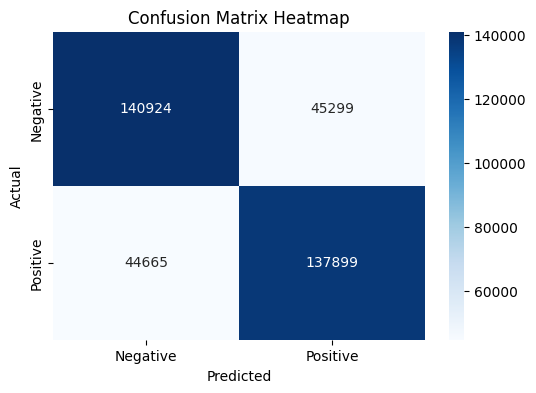

In [ ]:
# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# Visualizing confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()

In [ ]:
# Function to predict sentiment for new tweets
def predict_sentiment(tweet_texts):
    sample_df = pd.DataFrame({"tweet": tweet_texts})
    sample_df["clean_tweet"] = sample_df["tweet"].apply(preprocess_tweet)
    transformed_text = vectorizer.transform(sample_df["clean_tweet"])
    scaled_text = scaler.transform(transformed_text)
    predictions = model.predict(scaled_text)
    return ["Positive" if pred == 1 else "Negative" for pred in predictions]

# Testing with new tweets
new_tweets = ["I am so happy today!", "I hate when it rains all day.", "lol, I feel sad."]
predicted_sentiments = predict_sentiment(new_tweets)

for tweet, sentiment in zip(new_tweets, predicted_sentiments):
    print(f"Tweet: {tweet} | Sentiment: {sentiment}")

Tweet: I am so happy today! | Sentiment: Positive
Tweet: I hate when it rains all day. | Sentiment: Negative
Tweet: lol, I feel sad. | Sentiment: Negative



🔹 Model: Logistic Regression
Accuracy: 75.6060%
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76    186223
           1       0.75      0.76      0.75    182564

    accuracy                           0.76    368787
   macro avg       0.76      0.76      0.76    368787
weighted avg       0.76      0.76      0.76    368787



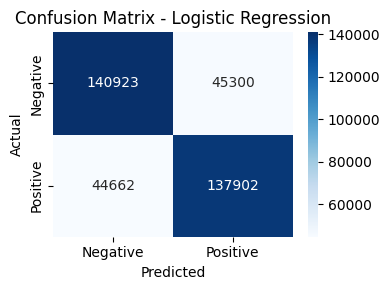


🔹 Model: Naive Bayes
Accuracy: 76.1819%
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.77      0.77    186223
           1       0.76      0.75      0.76    182564

    accuracy                           0.76    368787
   macro avg       0.76      0.76      0.76    368787
weighted avg       0.76      0.76      0.76    368787



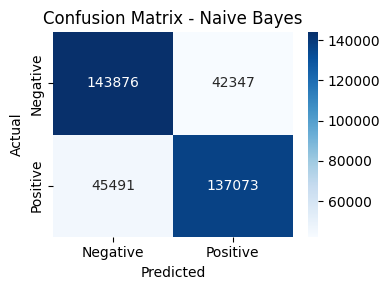


🔹 Model: Support Vector Machine
Accuracy: 75.9270%
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.74      0.76    186223
           1       0.75      0.78      0.76    182564

    accuracy                           0.76    368787
   macro avg       0.76      0.76      0.76    368787
weighted avg       0.76      0.76      0.76    368787



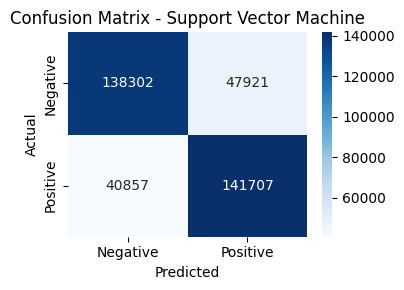

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Dictionary to hold models
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, solver="saga"),
    "Naive Bayes": MultinomialNB(),
    "Support Vector Machine": LinearSVC(),
}

# Train and evaluate all models
for name, clf in models.items():
    print(f"\n Model: {name}")

    # Some models (like MultinomialNB) require raw counts, not scaled data
    if name == "Naive Bayes":
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
    else:
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4%}")

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()
